# Supervised Learning Final Project
## Telcommunication Customer Churn Prediciton
### Problematic

For the project we will work on a classification prediction problem arround Churning. Churning in the context of company refers to the loss of clients or customers.
The objective of this project is to predict whether a customer will churn based on their historical data. 

We will use the Telecommunications Industry Sample Dataset prodived by IBM shared by BLASTCHAR on Kaggle:

Link : https://www.kaggle.com/datasets/blastchar/telco-customer-churn

Github : https://github.com/Adjouro/Supervised-Learning-Final-Project


### Libraries

In [177]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, precision_recall_curve, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

### Data Loading and Cleaning
The zip files contains 1 main csv file with 21 columns.
- CustomerID
- Gender
- SeniorCitizen
- Partner
- Dependents
- Tenure
- PhoneService
- MultipleLines
- InternetService
- OnlineSecurity
- OnlineBackup
- DeviceProtection
- TechSupport
- StreamingTV
- StreamingMovies
- Contract
- PaperlessBilling
- PaymentMethod
- MonthlyCharges
- TotalCharges
- Churn

In [178]:
#Loading 
data = pd.read_csv('/Users/charleskodio/Desktop/MS-DS/[5509] Introduction to Machine Learning - Supervised Learning/final project/Telco-Customer-Churn.csv', sep=',', on_bad_lines='skip')
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [179]:
# Cleaning of necessary
# Description and check for missing values
data.info()
data.describe(include='all')
data.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

no missing value; great ! We still need to convert TotalCharges from object to float

In [180]:
#convert TotalCharges to numeric values
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce')
data = data.dropna()

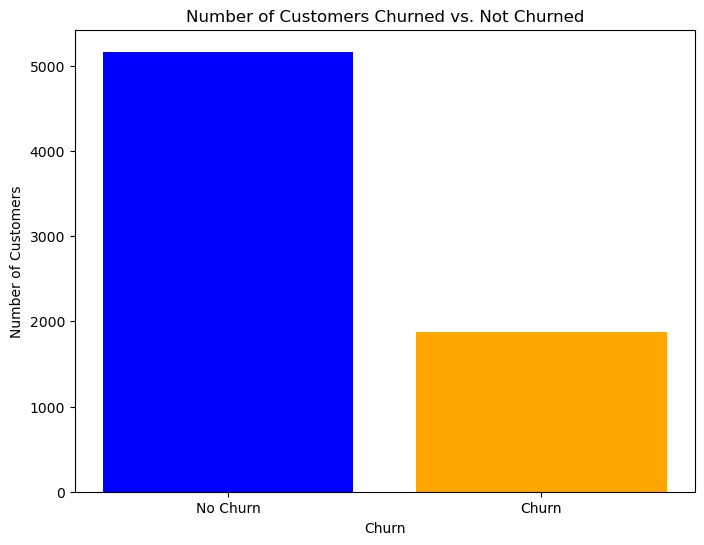

In [181]:
# Compute the count of churned and non-churned customers
churn_counts = data['Churn'].value_counts()

# Plot the distribution
plt.figure(figsize=(8, 6))
plt.bar(churn_counts.index, churn_counts.values, color=['blue', 'orange'])
plt.xticks([0, 1], ['No Churn', 'Churn'])
plt.xlabel('Churn')
plt.ylabel('Number of Customers')
plt.title('Number of Customers Churned vs. Not Churned')
plt.show()


**Conclusion:**

The dataset doesn't contains more missing values. If it was the case we could have :
- delete the missing rows
- estimate the missing values using a KNN (K nearest Neighbors) model
- estimate the missing values with the mean or median
- estimate the missing values with a linear regression model


### Data preprocessing
Now, we need to preprocess the data before doing the analysis. 
Categorical variables are encoded using one-hot encoding. 
This process converts categorical data into a format that can be provided to ML algorithms to do a better job in prediction.

In [182]:
# Convert categorical variables to numerical
data = pd.get_dummies(data, drop_first=True)

# Define features and target variable
X = data.drop('Churn_Yes', axis=1)
y = data['Churn_Yes']


In [183]:
#Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [184]:
# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Training : Machine Learning Model

In [185]:
#define mode fit
# Initialize models
models = {
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier()
}
# Train models
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    print(f'{name}:')
    print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
    print(f'Precision: {precision_score(y_test, y_pred)}')
    print(f'Recall: {recall_score(y_test, y_pred)}')
    print(f'F1 Score: {f1_score(y_test, y_pred)}\n')


Logistic Regression:
Accuracy: 0.7810945273631841
Precision: 0.7171052631578947
Recall: 0.2914438502673797
F1 Score: 0.41444866920152085

Random Forest:
Accuracy: 0.7903340440653873
Precision: 0.6573705179282868
Recall: 0.4411764705882353
F1 Score: 0.5279999999999999

Gradient Boosting:
Accuracy: 0.7945984363894811
Precision: 0.660377358490566
Recall: 0.4679144385026738
F1 Score: 0.5477308294209703



### Evaluate model : comparaison

**Model Performance**

The performance of the models was evaluated using accuracy, precision, recall, and F1-score.

## Model Comparison

| Metric       | Logistic Regression | Random Forest       | Gradient Boosting   |
|--------------|---------------------|---------------------|---------------------|
| Accuracy     | 78.11%              | 79.03%              | 79.45%              |
| Precision    | 71.71%              | 65.73%              | 65.73%              |
| Recall       | 29.14%              | 44.11%              | 46.79%              |
| F1-Score     | 41.44%              | 52.79%              | 54.77%              |

The **Gradient Boosting** model performed the best among the three models with the highest accuracy, recall, and F1-score.

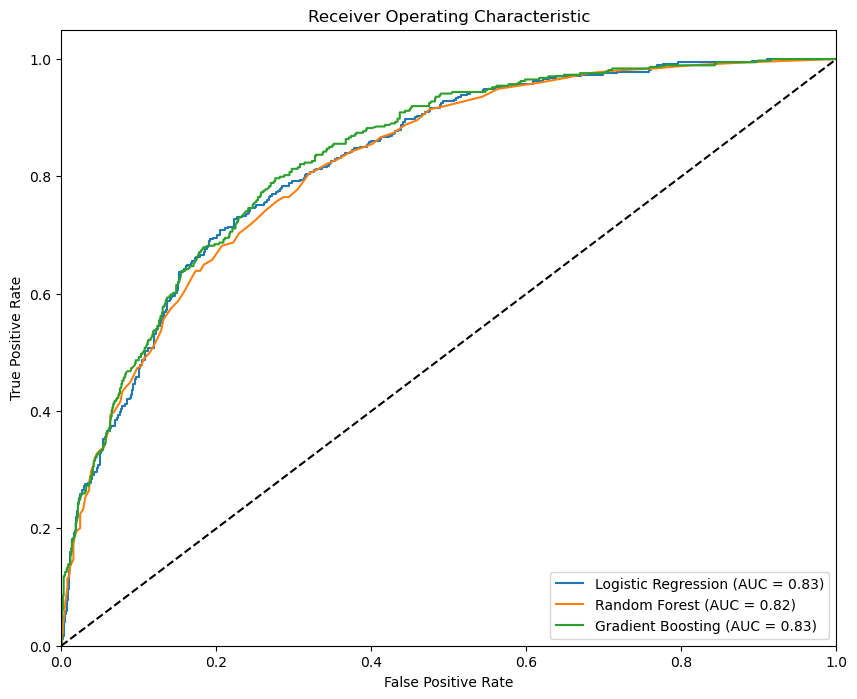

In [186]:
# Plot ROC Curves
plt.figure(figsize=(10, 8))

for name, model in models.items():
    y_prob = model.predict_proba(X_test_scaled)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()


The ROC curve looks good with an AUC of 0.83 for Logistic Regression and Gradient Boosting. We can conclude that Gradient Boosting has a good ability to distinguish between the positive and negative classes. 
Let's perform some hyperparameter boosting using an ensemble learning technique called Gradient Boosting. it combines the predictions of multiple weak learners to produce a strong predictive model.

In [188]:
# Hyperparameter tuning for Gradient Boosting
param_grid_gb = {
    'n_estimators': [50, 100],
    'learning_rate': [0.1],
    'max_depth': [3],
    'subsample': [0.8]
}


grid_search_gb = GridSearchCV(estimator=GradientBoostingClassifier(), param_grid=param_grid_gb, cv=2, n_jobs=-1, verbose=0)
grid_search_gb.fit(X_train_scaled, y_train)
best_gb = grid_search_gb.best_estimator_

# Evaluate the best Gradient Boosting model
y_pred_gb = best_gb.predict(X_test_scaled)
print(f'Gradient Boosting (Tuned):')
print(f'Accuracy: {accuracy_score(y_test, y_pred_gb)}')
print(f'Precision: {precision_score(y_test, y_pred_gb)}')
print(f'Recall: {recall_score(y_test, y_pred_gb)}')
print(f'F1 Score: {f1_score(y_test, y_pred_gb)}')

Gradient Boosting (Tuned):
Accuracy: 0.7945984363894811
Precision: 0.6591760299625468
Recall: 0.47058823529411764
F1 Score: 0.549141965678627


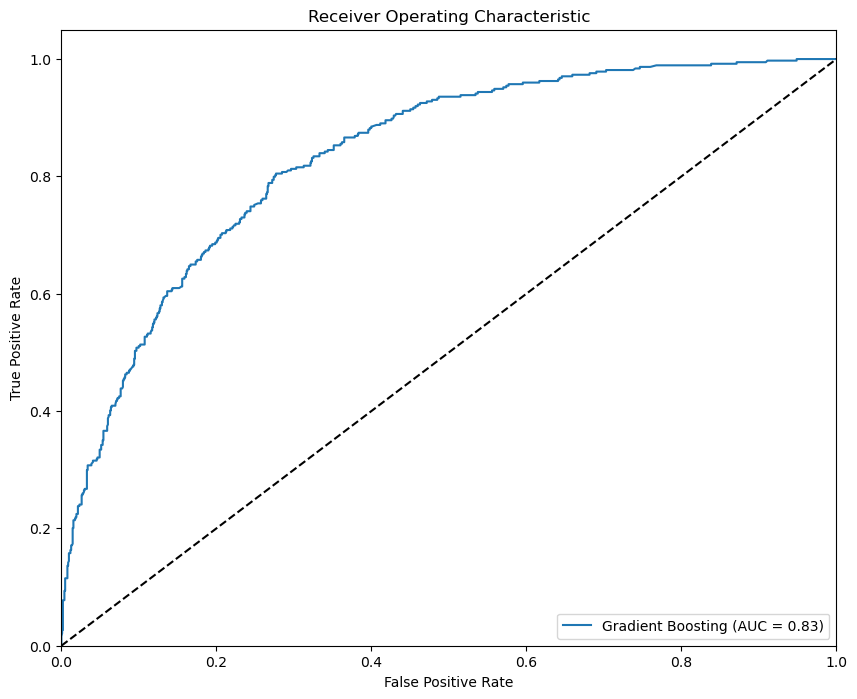

In [191]:
# Plot ROC Curve for Gradient Boosting
plt.figure(figsize=(10, 8))
y_prob_gb = best_gb.predict_proba(X_test_scaled)[:, 1]
fpr_gb, tpr_gb, _ = roc_curve(y_test, y_prob_gb)
roc_auc_gb = auc(fpr_gb, tpr_gb)
plt.plot(fpr_gb, tpr_gb, label=f'Gradient Boosting (AUC = {roc_auc_gb:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

### Vizualisation

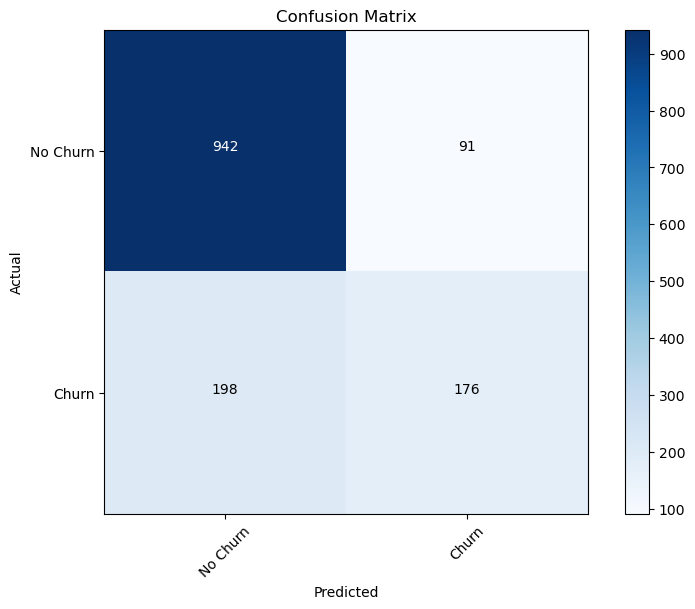

In [193]:
# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix_gb, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['No Churn', 'Churn'], rotation=45)
plt.yticks(tick_marks, ['No Churn', 'Churn'])

# Print the confusion matrix values on the plot
thresh = conf_matrix_gb.max() / 2.
for i, j in np.ndindex(conf_matrix_gb.shape):
    plt.text(j, i, format(conf_matrix_gb[i, j], 'd'),
             horizontalalignment="center",
             color="white" if conf_matrix_gb[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


### Conclusion

The objective of this project was to predict customer churn in the telecommunications industry using IBM data. After choose Gradient Boosting model, we trained the model and achieved the  performance metrics:

Accuracy: 79.46%
Precision: 65.92%
Recall: 47.06%
F1 Score: 54.91%

The model correctly identified a significant proportion of non-churn customers (True Negatives: 942) and a reasonable number of churn customers (True Positives: 176).
However, there is still room for improvement in reducing the number of false negatives (198), where the model missed predicting actual churn cases.


Our model demonstrates a strong ability to predict customer churn, achieving nearly 80% accuracy with a balanced precision and recall. This indicates that the model is effective in identifying customers at risk of churning based on historical data.

